In [1]:
import utils
import models
import re
import torch
import commons
import numpy as np

from torch.utils.data import DataLoader
from text.symbols import symbols
from data_utils import TextMelLoader, TextMelCollate
import re
from text import _clean_text

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [3]:
from text import text_to_sequence, cmudict
hps = utils.get_hparams_from_file("./configs/base.json")
cmu_dict = cmudict.CMUDict(hps.data.cmudict_path)

In [4]:
import transformers
from transformers import DistilBertModel, DistilBertTokenizer, DistilBertConfig
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [5]:
class WordPhoneMelLoader(TextMelLoader):
    
    def __getitem__(self, index):
        audiopath, sent = self.audiopaths_and_text[index]
        phones, mel = self.get_mel_text_pair((audiopath, sent))
        
        clean_sent = _clean_text(sent, ['english_cleaners'])
        wordpieces = tokenizer.encode(clean_sent, add_special_tokens=True)
        wordpieces = torch.IntTensor(wordpieces)

        words = clean_sent.split(" ")
        wordpiece_attn = torch.zeros((len(wordpieces), len(words)))
        phone_attn = torch.zeros((len(phones), len(words)))

        wp_idx = 0
        ph_idx = 0
        wordpieces_ = wordpieces.numpy()
        phones_ = phones.numpy()

        for i, word in enumerate(words):
            phs = text_to_sequence(word, ['english_cleaners'], cmu_dict)
            wps = tokenizer.encode(word, add_special_tokens=False)

            while np.any(wordpieces_[wp_idx:wp_idx+len(wps)] - wps):
                if wp_idx + len(wps) >= len(wordpieces_):
                    break
                wp_idx += 1
            if not np.any(wordpieces_[wp_idx:wp_idx+len(wps)] - wps):
                wordpiece_attn[wp_idx:wp_idx +len(wps), i] = 1
            
            while np.any(phones_[ph_idx:ph_idx+len(phs)] - phs):
                if ph_idx + len(phs) >= len(phones_):
                    break
                ph_idx += 1
            if not np.any(phones_[ph_idx:ph_idx+len(phs)] - phs):
                phone_attn[ph_idx:ph_idx + len(phs), i] = 1
                if ph_idx+len(phs) < len(phones_) and phones_[ph_idx+len(phs)] == 11:
                    phone_attn[ph_idx+len(phs), i] = 1
                    ph_idx += 1 
                    
        assert torch.all(wordpiece_attn.sum(dim=0))
        assert torch.all(phone_attn.sum(dim=0))
        
        return wordpieces, phones, mel, wordpiece_attn, phone_attn

In [6]:
class WordPhoneMelCollate(TextMelCollate):
    
    def __call__(self, batch):
        text_lengths = torch.LongTensor([len(x[0]) for x in batch])
        max_text_len = max(text_lengths)
        text_padded = torch.LongTensor(len(batch), max_text_len)
        text_padded.zero_()
        for i in range(len(batch)):
            text = batch[i][0]
            text_padded[i, :text.size(0)] = text

        phone_lengths = torch.LongTensor([len(x[1]) for x in batch])
        max_phone_len = max(phone_lengths)
        phones_padded = torch.LongTensor(len(batch), max_phone_len)
        phones_padded.zero_()
        for i in range(len(batch)):
            phones = batch[i][1]
            phones_padded[i, :phones.size(0)] = phones
    
        num_mels = batch[0][2].size(0)
        max_target_len = max([x[2].size(1) for x in batch])
        if max_target_len % self.n_frames_per_step != 0:
            max_target_len += self.n_frames_per_step - max_target_len % self.n_frames_per_step
            assert max_target_len % self.n_frames_per_step == 0
        mel_padded = torch.FloatTensor(len(batch), num_mels, max_target_len)
        mel_padded.zero_()
        mel_lengths = torch.LongTensor(len(batch))
        for i in range(len(batch)):
            mel = batch[i][2]
            mel_padded[i, :, :mel.size(1)] = mel
            mel_lengths[i] = mel.size(1)
            
        max_word_count = max([x[3].size(1) for x in batch])
        wordpiece_attn_padded = torch.zeros((len(batch), max_text_len, max_word_count))
        phone_attn_padded = torch.zeros((len(batch), max_phone_len, max_word_count))
        for i in range(len(batch)):
            wordpiece_attn_padded[i, :batch[i][3].size(0), :batch[i][3].size(1)] = batch[i][3]
            phone_attn_padded[i, :batch[i][4].size(0), :batch[i][4].size(1)] = batch[i][4]
        
        return text_padded, text_lengths, phones_padded, phone_lengths, mel_padded, mel_lengths, wordpiece_attn_padded, phone_attn_padded

In [10]:
collate_fn = WordPhoneMelCollate(1)

train_dataset = WordPhoneMelLoader(hps.data.training_files, hps.data)
train_loader = DataLoader(train_dataset, num_workers=8, shuffle=False,
      batch_size=hps.train.batch_size, pin_memory=True,
      drop_last=True, collate_fn=collate_fn)

test_dataset = WordPhoneMelLoader('filelists/ljs_audio_text_test_filelist.txt', hps.data)
test_loader = DataLoader(test_dataset, num_workers=8, shuffle=False,
      batch_size=hps.train.batch_size, pin_memory=True,
      drop_last=True, collate_fn=collate_fn)

In [11]:
hps = utils.get_hparams_from_file("./configs/base.json")
checkpoint_path = "pretrained/pretrained.pth"

model = models.FlowGenerator(
    len(symbols) + getattr(hps.data, "add_blank", False),
    out_channels=hps.data.n_mel_channels,
    **hps.model).to("cuda")

utils.load_checkpoint(checkpoint_path, model)
model.decoder.store_inverse() # do not calcuate jacobians for fast decoding
generator = model
_ = generator.eval()

In [12]:
import torch.nn as nn
import torch.optim as optim

class BertLinearLP(nn.Module):
    
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.dim = self.bert.config.dim
        self.ph_projs = nn.Embedding(len(symbols)+1, self.dim * 80)
    
    def forward(self, wp, ph, wp_attn, ph_attn, attn):
        wp_embed = self.bert(wp)[0]  # [b, #wp, dim=768]
        word_embed = torch.einsum('bpd, bpw -> bwd', wp_embed, wp_attn)
        wp_per_word = torch.sum(wp_attn, dim=1).unsqueeze(dim=-1)
        word_embed = word_embed / torch.maximum(wp_per_word, torch.ones_like(wp_per_word)) # [b, #w, dim]
        ph_embed = torch.einsum('bwd, bpw -> bpd', word_embed, ph_attn) # [b, #ph, dim]
    
        ph_proj = self.ph_projs(ph) # [b, #ph, dim*80]
        ph_proj_mats = torch.reshape(ph_proj, (ph_proj.shape[0], ph_proj.shape[1], self.dim, 80))
        x = torch.einsum('bpd, bpdl -> blp', ph_embed, ph_proj_mats)
        z = torch.matmul(attn.squeeze(1).transpose(1, 2), x.transpose(1, 2)).transpose(1, 2)
        return z

In [16]:
from tqdm import tqdm

def train(num_epochs, model, opt):
    model.train()
    #print('Control ', evaluate_control())
    log = {'train':[], 'test':[]}
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (wp, wp_len, ph, ph_len, mel, mel_len, wp_attn, ph_attn) in tqdm(enumerate(train_loader)):
            with torch.no_grad():
                wp, wp_len = wp.cuda(), wp_len.cuda()
                ph, ph_len = ph.cuda(), ph_len.cuda()
                mel, mel_len = mel.cuda(), mel_len.cuda()
                wp_attn, ph_attn = wp_attn.float().cuda(), ph_attn.float().cuda() # [b, #wp, #wrds], [b, #ph, #wrds]

                (z, z_m, z_logs, logdet, z_mask), (x_m, x_logs, x_mask), (attn, logw, logw_) = \
                    generator(ph, ph_len, mel, mel_len, gen=False)
                
            z_bert = model(wp, ph, wp_attn, ph_attn, attn)
            #loss = commons.mle_loss(z, z_m+z_bert, z_logs, logdet, z_mask)
            loss = commons.mle_loss(z, z_bert, z_logs, logdet, z_mask)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()
            
        train_loss = total_loss / len(train_loader)
        test_loss = evaluate(model)
        print('Train, Test:')
        print(train_loss, test_loss)
        log['train'].append(train_loss)
        log['test'].append(test_loss)
    return log
    
def evaluate(model):
    model.eval()
    total_loss = 0 
    with torch.no_grad():
        for batch_idx, (wp, wp_len, ph, ph_len, mel, mel_len, wp_attn, ph_attn) in enumerate(test_loader):
            wp, wp_len = wp.cuda(), wp_len.cuda()
            ph, ph_len = ph.cuda(), ph_len.cuda()
            mel, mel_len = mel.cuda(), mel_len.cuda()
            wp_attn, ph_attn = wp_attn.float().cuda(), ph_attn.float().cuda() # [b, #wp, #wrds], [b, #ph, #wrds]

            (z, z_m, z_logs, logdet, z_mask), (x_m, x_logs, x_mask), (attn, logw, logw_) = \
                generator(ph, ph_len, mel, mel_len, gen=False)

            
            z_bert = model(wp, ph, wp_attn, ph_attn, attn)
            #loss = commons.mle_loss(z, z_m+z_bert, z_logs, logdet, z_mask)
            loss = commons.mle_loss(z, z_bert, z_logs, logdet, z_mask)
            
            
            total_loss += loss.item()
            
    return total_loss / len(test_loader)

def evaluate_control():
    total_loss = 0 
    with torch.no_grad():
        for batch_idx, (wp, wp_len, ph, ph_len, mel, mel_len, wp_attn, ph_attn) in enumerate(test_loader):
            wp, wp_len = wp.cuda(), wp_len.cuda()
            ph, ph_len = ph.cuda(), ph_len.cuda()
            mel, mel_len = mel.cuda(), mel_len.cuda()
            wp_attn, ph_attn = wp_attn.float().cuda(), ph_attn.float().cuda() # [b, #wp, #wrds], [b, #ph, #wrds]

            (z, z_m, z_logs, logdet, z_mask), (x_m, x_logs, x_mask), (attn, logw, logw_) = \
                generator(ph, ph_len, mel, mel_len, gen=False)
            
            loss = commons.mle_loss(z, z_m, z_logs, logdet, z_mask)
            
            total_loss += loss.item()
    return total_loss / len(test_loader)

In [23]:
evaluate_control()

KeyboardInterrupt: 

In [13]:
bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
lp = BertLinearLP(bert).cuda()
optimizer = optim.Adam(lp.parameters(), lr=1e-5)

In [13]:
untrained_bert = DistilBertModel(DistilBertConfig())
lp_control = BertLinearLP(untrained_bert).cuda()
optimizer_control = optim.Adam(lp_control.parameters(), lr=1e-5)

In [29]:
log = train(20, lp, optimizer)
log_control = train(20, lp_control, optimizer_control)

390it [03:25,  1.90it/s]


Train, Test:
112.50135899079152 55.35756988525391


390it [03:25,  1.90it/s]


Train, Test:
45.273293558756514 37.74071248372396


390it [03:29,  1.86it/s]


Train, Test:
34.37184526003324 31.00193608601888


390it [03:29,  1.86it/s]


Train, Test:
27.76936887105306 28.821146519978843


390it [03:29,  1.86it/s]


Train, Test:
23.128089875441333 18.104911677042644


390it [03:30,  1.85it/s]


Train, Test:
17.293062393481915 15.071093877156576


390it [03:27,  1.88it/s]


Train, Test:
13.650272829104692 12.762255414326985


390it [03:29,  1.86it/s]


Train, Test:
11.71633831048623 10.625585746765136


390it [03:29,  1.86it/s]


Train, Test:
9.421449625797761 8.387213675181071


390it [03:30,  1.85it/s]


Train, Test:
7.356309830836761 6.480639934539795


390it [03:29,  1.86it/s]


Train, Test:
5.465555655650603 4.888082345326741


390it [03:32,  1.84it/s]


Train, Test:
4.120218339944497 3.7103049914042154


390it [03:30,  1.86it/s]


Train, Test:
3.1706073571474125 2.849638303120931


390it [03:29,  1.86it/s]


Train, Test:
2.418672336370517 2.1383532762527464


390it [03:29,  1.87it/s]


Train, Test:
1.9278725407062434 1.7124805291493734


390it [03:29,  1.86it/s]


Train, Test:
1.4242950277450757 1.264572258790334


390it [03:28,  1.87it/s]


Train, Test:
1.0909640432932437 1.0144292950630187


390it [03:29,  1.86it/s]


Train, Test:
0.8449336249858905 0.7829905311266582


390it [03:27,  1.88it/s]


Train, Test:
0.6927620685253388 0.6057421962420145


390it [02:34,  2.52it/s]


Train, Test:
0.5186443076683924 0.451876825094223


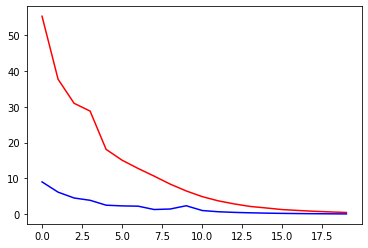

In [31]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(log_control['test'], c='r')
plt.plot(log['test'], c='b')

In [14]:
lp.load_state_dict(torch.load('checkpoints/latent-predictor_nn'))
#lp_control.load_state_dict(torch.load('checkpoints/latent_predictor_control'))

NameError: name 'lp_control' is not defined

In [17]:
evaluate(lp)

0.054049071311950685

In [21]:
def infer(generator, model, x, x_lengths, wp, wp_attn, ph_attn, g=None):
    noise_scale = 1.
    length_scale = 1.
    x_m, x_logs, logw, x_mask = generator.encoder(x, x_lengths, g=g)
    
    w = torch.exp(logw) * x_mask * length_scale
    w_ceil = torch.ceil(w)
    y_lengths = torch.clamp_min(torch.sum(w_ceil, [1, 2]), 1).long()
    y_max_length = None
    
    y, y_lengths, y_max_length = generator.preprocess(None, y_lengths, y_max_length)
    z_mask = torch.unsqueeze(commons.sequence_mask(y_lengths, y_max_length), 1).to(x_mask.dtype)
    attn_mask = torch.unsqueeze(x_mask, -1) * torch.unsqueeze(z_mask, 2)
    
    attn = commons.generate_path(w_ceil.squeeze(1), attn_mask.squeeze(1)).unsqueeze(1)
    # z_m = torch.matmul(attn.squeeze(1).transpose(1, 2), x_m.transpose(1, 2)).transpose(1, 2) # [b, t', t], [b, t, d] -> [b, d, t']
    z_logs = torch.matmul(attn.squeeze(1).transpose(1, 2), x_logs.transpose(1, 2)).transpose(1, 2) # [b, t', t], [b, t, d] -> [b, d, t']
    logw_ = torch.log(1e-8 + torch.sum(attn, -1)) * x_mask
    
    z_bert = model(wp, x, wp_attn, ph_attn, attn)
    
    z = (z_bert + torch.exp(z_logs) * torch.randn_like(z_bert) * noise_scale) * z_mask
    
    y, logdet = generator.decoder(z, z_mask, g=g, reverse=True)
    return (y, z_bert, z_logs, logdet, z_mask), (x_m, x_logs, x_mask), (attn, logw, logw_)


with torch.no_grad():
    for batch_idx, (wp, wp_len, ph, ph_len, mel, mel_len, wp_attn, ph_attn) in enumerate(train_loader):
        wp, wp_len = wp.cuda(), wp_len.cuda()
        ph, ph_len = ph.cuda(), ph_len.cuda()
        mel, mel_len = mel.cuda(), mel_len.cuda()
        wp_attn, ph_attn = wp_attn.float().cuda(), ph_attn.float().cuda() # [b, #wp, #wrds], [b, #ph, #wrds]


        (y, *_), *_, (attn, logw, _) = infer(generator, lp, ph, ph_len, wp, wp_attn, ph_attn)
        break
